# Dataset Collecting with Polars

In this notebook we will use our trained CNN model to get embedding from all images we have. Will save these embeddings as new dataset, further we will use it to train our Feedforward MLP Model. And it's first time I will use Polars for data manipulation.

## Packages and requirements

In [1]:
# Major builtin libraries
import os
# import cv2
# import math
import time
import typing as t

In [2]:
# Classic packages for data manipulation and visualization
import numpy as np
import pandas as pd
import polars as pl

In [3]:
# Basic PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # For custom data presentation

In [4]:
# Utils
import joblib  # Pipelining, pickling (dump/load), parallel processing
from tqdm import tqdm  # Progress bar for training process

In [5]:
# Torch Computer Vision tools for images processing
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision import models  # Pretrained models

In [6]:
# Albumentations is an OS library for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# import torchvision.transforms as T  # We can use torch augmentations instead

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Configuration

In [7]:
CONFIG = {
    "image_dimension": 256,
    # "train_batch_size": 220,
    "val_batch_size": 600,
}

In [8]:
class Config:
    """
    Class to simplify access to Config: not dict but object with attributes
    """
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [9]:
config = Config(config_dict=CONFIG)
del CONFIG # We can delete is

# 2. Data

## Set data location

In [10]:
config.repo = 'car-brands/'  # dataset name on Kaggle

config.root = '/kaggle/input/' + config.repo

config.data = config.root

config.train_images_path  = config.data + 'images/train'
config.test_images_path = config.data + 'images/test'

config.train_labels  = config.data + 'train_labels.csv'
config.test_labels = config.data + 'test_labels.csv'

config.dataframe_path = 'embeddings_and_labels.csv'  # All data in one place. That will be a result of work in this notebook

config.embedding_model_path = '/kaggle/input/efficient-model/ArcFace_mobilenet_v2.pth'

## Work with .csv

Firstly, let's get images paths.

In [11]:
train_images_df = pl.read_csv(config.train_labels)

In [12]:
def get_file_path_by_id(file_id, dir=config.root):
    return os.path.join(dir, str(file_id) + ".jpg")

In [13]:
train_images_df = train_images_df.with_columns(
    pl.struct(['id']).apply(lambda x: get_file_path_by_id(x['id'], dir=config.train_images_path)).alias('file_path')
)

In [14]:
train_images_df['file_path'][0]

'/kaggle/input/car-brands/images/train/1.jpg'

Let's make sure that the paths are correct:

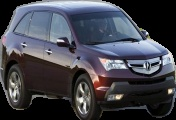

In [15]:
to_pil_image(read_image(train_images_df['file_path'][0]))

Now we do the same with test images:

In [16]:
test_images_df = pl.read_csv(config.test_labels)
test_images_df = test_images_df.with_columns(
    pl.struct(['id']).apply(lambda x: get_file_path_by_id(x['id'], dir=config.test_images_path)).alias('file_path')
)
test_images_df.head(2)

id,label,file_path
i64,str,str
1,"""Acura_MDX""","""/kaggle/input/…"
2,"""Acura_MDX""","""/kaggle/input/…"


## Merge two dataframes into one

In [17]:
print(train_images_df.shape)

(21789, 3)


Our train dataset ends with following value:

In [18]:
bound_value = train_images_df['id'][-1]
bound_value

21789

So, our test dataset must start with next integer before we begin to concatenate both.

We apply a function that will replace (shift) our items id.

In [19]:
# Use polars syntax
test_images_df = test_images_df.with_columns(
    pl.col('id').map(lambda x: x + bound_value).alias('id')
)

In [20]:
print(test_images_df[0])

shape: (1, 3)
┌───────┬───────────┬───────────────────────────────────┐
│ id    ┆ label     ┆ file_path                         │
│ ---   ┆ ---       ┆ ---                               │
│ i64   ┆ str       ┆ str                               │
╞═══════╪═══════════╪═══════════════════════════════════╡
│ 21790 ┆ Acura_MDX ┆ /kaggle/input/car-brands/images/… │
└───────┴───────────┴───────────────────────────────────┘


Now the count doesn't start from the beginning (1) but continues (from 21790). Note that it doesn't affect files path. We can join frames into one now.

In [21]:
images_df = pl.concat([train_images_df, test_images_df], how='vertical',)
images_df.shape

(24564, 3)

Let's check that dataframes were concatenated properly.

In [22]:
for i, id in enumerate(images_df['id']):
    try:
        assert i+1 == id
    except:
        print(i, id)
        raise
print("Success!")

Success!


## Building of Pytorch dataset

We use Albumantations lib to normalize the future tensors:

In [23]:
data_transforms = {
    # Only validation is needed.

    "val": A.Compose([
        #         A.ToRGB(),
        A.Resize(config.image_dimension, config.image_dimension),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0
        ),
        ToTensorV2()], p=1.)
}

In [24]:
class CustomImagesDataset(Dataset):
    """
    """
    def __init__(self, data: pd.DataFrame=None, images_path: os.path=None, labels_path:os.path=None, transform_images: A.Compose=None,):
        """

        """
        super().__init__()
        assert (data is not None) or (labels_path is not None and images_path is not None)

        if data is None:
            data = pd.read_csv(labels_path)
            data['file_path'] = data['id'].apply(get_file_path_by_id, dir=images_path)

        self.images_paths = data['file_path']
        self.labels = data['label']
#         self.indexes = data['id'].values
        self.transform_images = transform_images
        self.__set_dataset_len()

    def __set_dataset_len(self):
        self.length = self.labels.shape[0] # Number of rows

    def __len__(self):
        """
        We calculate the len in another function, so that we are able to slice.
        """
        return self.length

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        """ Function to return item by indexing the dataset """

        if not isinstance(index, int) and isinstance(index, slice):
            # It's not an index, but slice.
            # We will return the part of data by making a copy of the dataset
            index: slice
            self = deepcopy(self)
            self.length = index.stop  # Cut the length of dataset.
            self.labels = self.labels[:self.length]
            return self
        assert self.__len__() >= index

        image = to_pil_image(read_image(self.images_paths[index]))
        if self.transform_images:
            # Albumentations requires us to convert image to Numpy Array
            image = self.transform_images(image=np.array(image))['image']

        label = self.labels[index]
        return image, label


In [25]:
images_dataset = CustomImagesDataset(data=images_df, transform_images=data_transforms['val'],)

Audi_A1


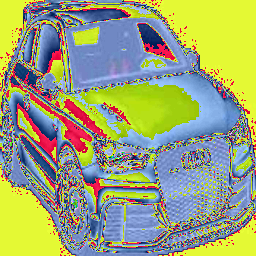

In [26]:
print(images_dataset[60][1])
to_pil_image(images_dataset[60][0])

## 1. Pretrained SOTA model to get the embeddings

In [27]:
def get_input_feature_size(classifier: nn.Sequential) -> int:
    for module in classifier.modules():
        if isinstance(module, nn.Linear):
            return module.in_features

Let's use a universal function that we made before.

In [28]:
def get_model(model_name='resnet18', from_path=None, pretrained=False, freeze_layers=0.0, get_embeddings=False) -> torch.nn.Module:
    """
        Multipurpose function to load the model. For our task we will use fully trained model. If you don't have such, you may
    download any pretrained model cut last layer - you both `pretrained` and `get_embeddings` set to True.
    :param model_name:
    :param get_embeddings: whether to cut the classifier layer
    :return:
    """
    if from_path:
        try:
            model = torch.load(from_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            return model
        except FileNotFoundError:
            raise
    elif model_name:
        model = getattr(models, model_name) # We use builtin function
        model = model(
        weights=('DEFAULT' if pretrained else None)
        )

    if bool(freeze_layers):
        params = list(model.parameters())
        for param in params[:int(len(params)*freeze_layers)]:
            # Freeze some layers
            param.requires_grad = False

    if get_embeddings:
        # That means remove classifier (last layer):
        model.classifier = nn.Sequential(
            # nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features=get_input_feature_size(model.classifier),
                      out_features=config.embedding_size, bias=True
                      ),

        )
    return model

In [29]:
embedding_model = get_model(
    from_path=config.embedding_model_path,
)
# embedding_model

It is a model that doesn't have classifier - only one linear layer that transforms embeddings to desired size

In [30]:
embedding_model.classifier

Sequential(
  (0): Linear(in_features=960, out_features=512, bias=True)
)

## Device

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = embedding_model.to(device)
torch.cuda.empty_cache()

In [32]:
images_dataloader = DataLoader(images_dataset,
                              batch_size=config.val_batch_size,
                              shuffle=False,
                              num_workers=os.cpu_count() % 4,
)

## Embeddings processing

In [33]:
@torch.inference_mode()
def get_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    # all_labels = []

    with tqdm(dataloader, desc="Processing",unit="batch") as process:
        for images, labels in process:
            images = images.to(device)
            # labels = labels.to(device)
            embeddings = model(images)

            all_embeddings.append(embeddings)
            # all_labels.append(labels)

    return torch.cat(all_embeddings)


In [34]:
embeddings_bag = get_embeddings(embedding_model, images_dataloader, device)

Processing: 100%|██████████| 41/41 [03:08<00:00,  4.60s/batch]


In [35]:
embeddings_bag.size()

torch.Size([24564, 512])

In [36]:
embeddings_bag = embeddings_bag.cpu().numpy()

In [37]:
embeddings_df = pl.from_numpy(embeddings_bag,
              schema=list(
                  map(lambda x: str(x),
                  list(range(embeddings_bag.shape[1]))
                )
              )  # Set columns as numbers from 0 to embedding size - 1
)
embeddings_df.head()

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
-0.001561,0.159091,-0.326709,-0.226603,-0.097365,0.204614,-0.142634,0.208764,0.469837,0.069866,-0.214199,0.078432,0.059433,-0.255648,0.465814,0.130633,-0.138551,-0.087654,0.376801,-0.102735,0.315953,-0.364239,-0.297658,-0.086533,0.026685,-0.166138,0.485222,-0.70863,0.059533,0.286716,0.452996,-0.072838,0.101409,0.262743,0.222803,0.024834,-0.116272,…,0.113709,-0.186677,-0.298899,0.245753,-0.097061,-0.130924,-0.357984,-0.411139,0.366418,-0.427736,-0.124948,-0.448462,0.071178,-0.067794,-0.111349,0.170131,0.31933,-0.16849,-0.118607,-0.114619,-0.149445,-0.08156,0.031606,-0.222388,0.304512,-0.372294,0.194721,0.111356,0.410457,-0.024682,0.178265,-0.35734,-0.073279,0.190458,-0.060786,0.364546,0.824516
0.229466,-0.186505,-0.329016,-0.650666,0.115301,0.149208,0.065496,0.191487,0.42892,-0.016147,0.139406,0.066333,-0.27887,-0.148158,0.017281,0.318445,-0.079015,0.034666,0.446652,-0.258744,0.35744,-0.114873,0.061385,-0.517343,0.103641,-0.10283,0.589982,-0.1825,-0.169097,0.031267,0.293672,0.10812,-0.290676,0.113232,0.126679,0.037752,-0.091028,…,0.260027,-0.165166,-0.30908,0.175681,0.093439,-0.388641,-0.392741,-0.058004,0.206543,-0.260815,0.161926,-0.213868,0.312559,-0.21701,-0.212913,0.043407,-0.052148,-0.355319,-0.315214,-0.136098,0.074147,-0.081456,-0.059186,-0.175451,0.328775,-0.197459,0.171962,0.13534,0.195697,0.171068,0.037157,0.049534,-0.224402,0.225593,0.180314,0.073213,0.500426
-0.203165,0.330612,-0.413488,-0.128357,0.013811,0.244605,-0.137738,0.365148,0.385303,0.318809,-0.177434,0.014444,-0.073377,-0.235376,0.410262,-0.03597,0.001357,-0.021293,0.50106,0.131379,0.404416,-0.336581,-0.256578,-0.027033,0.396875,-0.28554,0.422788,-0.650043,0.219724,0.361741,0.450733,-0.181746,0.196089,-0.05003,0.229581,0.067064,-0.167564,…,0.350391,-0.240519,-0.262738,0.209082,-0.241945,-0.288608,-0.388718,-0.250951,0.275043,-0.069686,-0.371757,-0.171901,-0.008264,-0.237953,-0.321406,0.259108,0.400673,-0.299547,0.054096,0.005741,-0.035825,-0.145263,-0.096771,-0.170139,0.263281,-0.153472,0.106789,-0.004684,0.413026,0.040102,0.054195,-0.251548,-0.020557,0.241178,0.0629,0.354683,0.59187
-0.052456,0.385235,-0.423291,-0.007358,0.031012,0.242327,0.118072,0.23562,0.464901,0.320997,-0.23691,-0.04943,0.11451,-0.169678,0.533801,-0.169033,0.048569,-0.086769,0.344593,-0.025558,0.184888,-0.275048,-0.274544,-0.0808,0.192704,-0.118977,0.302043,-0.721307,0.236126,0.448257,0.386802,-0.300737,0.157988,-0.101695,0.340388,0.085632,0.098532,…,0.423356,-0.315011,-0.254342,0.144064,-0.195568,-0.300371,-0.459397,-0.21723,0.159235,-0.129899,-0.349052,-0.081316,0.084587,-0.384839,-0.250533,0.194477,0.30682,-0.271959,0.172045,0.003072,-0.265631,-0.065971,0.032171,0.05684,0.19052,-0.225707,0.1255,0.095158,0.412529,0.0152,0.237078,-0.429586,-0.110773,0.166453,0.079581,0.243743,0.662615
0.092909,0.075529,-0.04049,0.137453,0.53128,0.219033,-0.100117,0.161784,-0.07792,-0.265161,-0.09375,-0.191496,-0.182768,0.202215,-0.081372,-0.003431,-0.301652,-0.155894,0.196843,-0.022968,-0.19679,-0.024239,0.087924,-0.339051,-0.053372,0.532928,0.375284,-0.260523,-0.268407,0.137507,0.268298,0.11258,-0.041074,0.099681,0.012165,0.157214,0.155911,…,0.076442,-0.195524,-0.167859,0.146799,0.172023,-0.204419,-0.288022,0.110002,0.052425,-0.345989,0.660531,-0.179124,-0.027644,-0.081305,-0.314022,0.273189,-0.139579,-0.100098,-0.220546,-0.402161,0.046665,0.006274,-0.211194,0.008769,0.082264,-0.160109,0.058212,-0.099583,-0.02452,0.143381,-0.099898,0.137324,0.137523,0.217806,0

Now we have dataframe of embeddings. Let's add here "label" column and then save to .csv.

In [38]:
labels = images_df.select(pl.col('label'))
labels.head()

label
str
"""Acura_MDX"""
"""Acura_MDX"""
"""Acura_MDX"""
"""Acura_MDX"""
"""Acura_MDX"""


In [39]:
result_df = pl.concat([embeddings_df, labels], how='horizontal',)
result_df.head()

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,label
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str
-0.001561,0.159091,-0.326709,-0.226603,-0.097365,0.204614,-0.142634,0.208764,0.469837,0.069866,-0.214199,0.078432,0.059433,-0.255648,0.465814,0.130633,-0.138551,-0.087654,0.376801,-0.102735,0.315953,-0.364239,-0.297658,-0.086533,0.026685,-0.166138,0.485222,-0.70863,0.059533,0.286716,0.452996,-0.072838,0.101409,0.262743,0.222803,0.024834,-0.116272,…,-0.186677,-0.298899,0.245753,-0.097061,-0.130924,-0.357984,-0.411139,0.366418,-0.427736,-0.124948,-0.448462,0.071178,-0.067794,-0.111349,0.170131,0.31933,-0.16849,-0.118607,-0.114619,-0.149445,-0.08156,0.031606,-0.222388,0.304512,-0.372294,0.194721,0.111356,0.410457,-0.024682,0.178265,-0.35734,-0.073279,0.190458,-0.060786,0.364546,0.824516,"""Acura_MDX"""
0.229466,-0.186505,-0.329016,-0.650666,0.115301,0.149208,0.065496,0.191487,0.42892,-0.016147,0.139406,0.066333,-0.27887,-0.148158,0.017281,0.318445,-0.079015,0.034666,0.446652,-0.258744,0.35744,-0.114873,0.061385,-0.517343,0.103641,-0.10283,0.589982,-0.1825,-0.169097,0.031267,0.293672,0.10812,-0.290676,0.113232,0.126679,0.037752,-0.091028,…,-0.165166,-0.30908,0.175681,0.093439,-0.388641,-0.392741,-0.058004,0.206543,-0.260815,0.161926,-0.213868,0.312559,-0.21701,-0.212913,0.043407,-0.052148,-0.355319,-0.315214,-0.136098,0.074147,-0.081456,-0.059186,-0.175451,0.328775,-0.197459,0.171962,0.13534,0.195697,0.171068,0.037157,0.049534,-0.224402,0.225593,0.180314,0.073213,0.500426,"""Acura_MDX"""
-0.203165,0.330612,-0.413488,-0.128357,0.013811,0.244605,-0.137738,0.365148,0.385303,0.318809,-0.177434,0.014444,-0.073377,-0.235376,0.410262,-0.03597,0.001357,-0.021293,0.50106,0.131379,0.404416,-0.336581,-0.256578,-0.027033,0.396875,-0.28554,0.422788,-0.650043,0.219724,0.361741,0.450733,-0.181746,0.196089,-0.05003,0.229581,0.067064,-0.167564,…,-0.240519,-0.262738,0.209082,-0.241945,-0.288608,-0.388718,-0.250951,0.275043,-0.069686,-0.371757,-0.171901,-0.008264,-0.237953,-0.321406,0.259108,0.400673,-0.299547,0.054096,0.005741,-0.035825,-0.145263,-0.096771,-0.170139,0.263281,-0.153472,0.106789,-0.004684,0.413026,0.040102,0.054195,-0.251548,-0.020557,0.241178,0.0629,0.354683,0.59187,"""Acura_MDX"""
-0.052456,0.385235,-0.423291,-0.007358,0.031012,0.242327,0.118072,0.23562,0.464901,0.320997,-0.23691,-0.04943,0.11451,-0.169678,0.533801,-0.169033,0.048569,-0.086769,0.344593,-0.025558,0.184888,-0.275048,-0.274544,-0.0808,0.192704,-0.118977,0.302043,-0.721307,0.236126,0.448257,0.386802,-0.300737,0.157988,-0.101695,0.340388,0.085632,0.098532,…,-0.315011,-0.254342,0.144064,-0.195568,-0.300371,-0.459397,-0.21723,0.159235,-0.129899,-0.349052,-0.081316,0.084587,-0.384839,-0.250533,0.194477,0.30682,-0.271959,0.172045,0.003072,-0.265631,-0.065971,0.032171,0.05684,0.19052,-0.225707,0.1255,0.095158,0.412529,0.0152,0.237078,-0.429586,-0.110773,0.166453,0.079581,0.243743,0.662615,"""Acura_MDX"""
0.092909,0.075529,-0.04049,0.137453,0.53128,0.219033,-0.100117,0.161784,-0.07792,-0.265161,-0.09375,-0.191496,-0.182768,0.202215,-0.081372,-0.003431,-0.301652,-0.155894,0.196843,-0.022968,-0.19679,-0.024239,0.087924,-0.339051,-0.053372,0.532928,0.375284,-0.260523,-0.268407,0.137507,0.268298,0.11258,-0.041074,0.099681,0.012165,0.157214,0.155911,…,-0.195524,-0.167859,0.146799,0.172023,-0.204419,-0.288022,0.110002,0.052425,-0.345989,0.660531,-0.179124,-0.027644,-0.081305,-0.314022,0.273189,-0.139579,-0.100098,-0.220546,-0.402161,0.046665,0.006274,-0.211194,0.008769,0.082264,-0.160109,0.058212,-0.099583,-0.02452,0.143381,-0.099898,0.13732

In [40]:
result_df.write_csv(config.dataframe_path)

In [41]:
print('Done!')

Done!
